In [ ]:
import os
import numpy as np
import gymnasium as gym
import pandas as pd
import numpy as np
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from pypfopt.efficient_frontier import EfficientFrontier
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
import matplotlib.pyplot as plt

check_and_make_directories([TRAINED_MODEL_DIR])

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
train = pd.read_csv('data/train.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

trade = pd.read_csv('data/trade.csv')
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [3]:
trade.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2022-07-01,136.581268,136.689409,133.366561,133.740127,71051600,AAPL,4,-2.301430,147.113372,125.673679,45.052143,-36.439940,16.701967,138.153920,147.386975,26.700001,29.539496
0,2022-07-01,221.445786,221.851609,217.089917,219.371560,2745500,AMGN,4,0.040362,226.490870,209.156271,53.167819,-6.989030,3.272451,220.758292,220.249517,26.700001,29.539496
0,2022-07-01,134.745270,135.215540,131.933285,132.509125,2625300,AXP,4,-5.872341,162.851657,122.620482,40.059075,-91.688955,37.193593,146.824642,156.516553,26.700001,29.539496
0,2022-07-01,139.839996,141.789993,135.399994,135.880005,7627100,BA,4,0.295126,148.248396,122.092606,47.124452,74.248052,0.310288,132.643000,145.353833,26.700001,29.539496
0,2022-07-01,167.587509,170.435636,163.291847,168.546284,3423100,CAT,4,-8.327275,222.107130,155.122267,37.833418,-137.073967,45.987422,191.767993,197.011469,26.700001,29.539496


In [4]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [5]:
df_account_value_dt = pd.read_pickle('data/df_account_value_dt.pkl')
df_actions_dt = pd.read_pickle('data/df_actions_dt.pkl')

In [6]:
df_account_value_ppo = pd.read_pickle('data/df_account_value_ppo.pkl')
df_actions_ppo = pd.read_pickle('data/df_actions_ppo.pkl')

In [7]:
# Helps us process data into a form for weight calculation
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [8]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[136.58126831, 221.44578552, 134.74526978, ...,  40.98118973,
         32.47948456,  39.16988754],
       [139.16682434, 222.50996399, 134.02546692, ...,  40.80659866,
         32.43736649,  39.68733978],
       [140.5038147 , 221.17521667, 132.58590698, ...,  40.87802124,
         31.82247734,  39.96842194],
       ...,
       [168.67868042, 257.03622437, 233.26693726, ...,  35.54792404,
         16.45373917,  59.25400162],
       [168.09291077, 257.60870361, 231.83052063, ...,  35.96485138,
         16.54722786,  59.20479965],
       [172.26293945, 263.7154541 , 235.05747986, ...,  36.33646393,
         16.84638596,  59.283535  ]], shape=(459, 29))

In [9]:
TradeData.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2022-07-01,136.581268,221.445786,134.745270,139.839996,167.587509,166.449097,38.319653,128.434250,94.563560,274.996887,...,83.830002,252.742844,95.991638,134.565140,160.636551,490.046234,194.335037,40.981190,32.479485,39.169888
2022-07-05,139.166824,222.509964,134.025467,137.699997,163.329483,170.407455,38.083675,125.059288,95.586502,273.131287,...,84.029556,255.926773,98.970634,133.266495,156.901703,478.529022,195.661942,40.806599,32.437366,39.687340
2022-07-06,140.503815,221.175217,132.585907,136.309998,161.966507,170.931931,38.746231,123.411209,94.504539,269.969849,...,84.474022,259.198181,98.885239,134.509888,159.435394,488.047729,196.227844,40.878021,31.822477,39.968422
2022-07-07,143.875854,223.132248,135.349915,139.970001,169.458069,174.801254,39.227272,125.813179,95.832405,274.417877,...,84.365173,261.330566,102.585258,134.463821,159.182022,487.185852,197.866989,40.749451,32.184669,40.029114
2022-07-08,144.554199,224.088165,136.050507,139.070007,168.348907,173.673111,39.381565,125.155678,94.288155,272.460358,...,84.156555,260.610077,102.395523,133.561264,158.590836,491.211182,198.618256,40.572666,31.628748,40.054668


In [10]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.131 0.062 0.089 0.067 0.07  0.115 0.052 0.05  0.059 0.063 0.093 0.07
 0.039 0.056 0.049 0.071 0.049 0.059 0.044 0.057 0.097 0.08  0.043 0.06
 0.108 0.097 0.039 0.038 0.039]
Variance-Covariance matrix of returns
 [[3.296 1.026 1.667 1.691 1.53  1.941 1.539 1.161 1.28  1.711 1.31  1.362
  1.116 1.697 0.707 1.68  0.704 0.88  1.139 0.763 1.709 1.368 0.743 0.955
  1.245 1.486 0.592 1.019 0.647]
 [1.026 2.489 1.19  1.025 1.086 1.205 1.044 0.953 0.941 1.139 0.986 1.022
  0.833 1.147 0.888 1.238 0.656 0.677 0.948 1.086 1.109 0.882 0.75  0.884
  1.192 1.04  0.65  1.036 0.635]
 [1.667 1.19  4.853 2.897 2.54  2.004 1.843 2.149 2.208 3.037 1.748 2.23
  1.529 1.939 0.937 3.582 1.106 1.242 1.74  1.107 1.764 1.841 0.93  1.909
  1.706 2.306 0.918 1.448 0.629]
 [1.691 1.025 2.897 5.287 2.373 1.957 1.651 2.167 2.096 2.428 1.645 2.315
  1.557 1.868 0.883 2.616 1.121 1.249 1.586 0.949 1.581 1.795 0.802 1.66
  1.565 1.836 0.769 1.472 0.601]
 [1.53  1.086 2.54  2.

In [11]:
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()

# Use shape of 'Last Price' in the range to avoid shape mismatch error
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])

mvo_weights

array([370280.,      0.,      0.,      0.,      0.,  36860.,      0.,
            0.,      0.,      0., 170290.,      0.,      0.,      0.,
         9030.,      0.,      0.,  25180.,      0.,  25760.,  32130.,
            0.,      0.,      0., 238790.,  91680.,      0.,      0.,
            0.])

In [12]:
mvo_weights.shape

(29,)

In [13]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])

In [14]:
LastPrice.shape

(29,)

In [15]:
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio

array([2754.882,    0.   ,    0.   ,    0.   ,    0.   ,  225.689,
          0.   ,    0.   ,    0.   ,    0.   ,  674.185,    0.   ,
          0.   ,    0.   ,   56.109,    0.   ,    0.   ,  109.879,
          0.   ,  311.502,  128.486,    0.   ,    0.   ,    0.   ,
        490.857,  477.25 ,    0.   ,    0.   ,    0.   ])

In [16]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

MVO_result

,Mean Var
2022-07-01,1.013916e+06
2022-07-05,1.020132e+06
2022-07-06,1.029265e+06
2022-07-07,1.042120e+06
2022-07-08,1.045793e+06
...,...
2024-04-23,1.226733e+06
2024-04-24,1.229648e+06
2024-04-25,1.233486e+06
2024-04-26,1.235324e+06


In [17]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2022-07-01'
TRADE_START_DATE = '2022-07-01'
TRADE_END_DATE = '2024-05-01'


In [18]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                        end_date = TRADE_END_DATE,
                        ticker_list = ['^dji']).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (460, 8)


In [19]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

In [20]:
df_result_dt = df_account_value_dt.set_index(df_account_value_dt.columns[0]) #if if_using_a2c else None

result = pd.DataFrame()
dt_result = pd.merge(result, df_result_dt, how='outer', left_index=True, right_index=True)

In [21]:
col_name = []
col_name.append('DT')
dt_result.columns = col_name

In [22]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) #if if_using_a2c else None

result = pd.DataFrame()
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)

In [23]:
col_name = []
col_name.append('PPO')
result.columns = col_name

In [24]:
result = pd.merge(result, dt_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

C:\Users\drebi\AppData\Local\Temp\ipykernel_36420\1187476257.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [25]:
result.rename(columns={'close':'DJI'}, inplace=True)


In [26]:
result

,PPO,DT,Mean Var,DJI
date,,,,
2022-07-01,1.000000e+06,1.000000e+06,1.013916e+06,1.000000e+06
2022-07-05,9.999428e+05,9.999347e+05,1.020132e+06,9.958376e+05
2022-07-06,9.997908e+05,9.996818e+05,1.029265e+06,9.980841e+05
2022-07-07,1.000457e+06,1.000475e+06,1.042120e+06,1.009238e+06
2022-07-08,1.000209e+06,1.000142e+06,1.045793e+06,1.007746e+06
...,...,...,...,...
2024-04-24,1.337196e+06,1.255384e+06,1.229648e+06,1.236795e+06
2024-04-25,1.319240e+06,1.245193e+06,1.233486e+06,1.224732e+06
2024-04-26,1.327525e+06,1.252811e+06,1.235324e+06,1.229679e+06


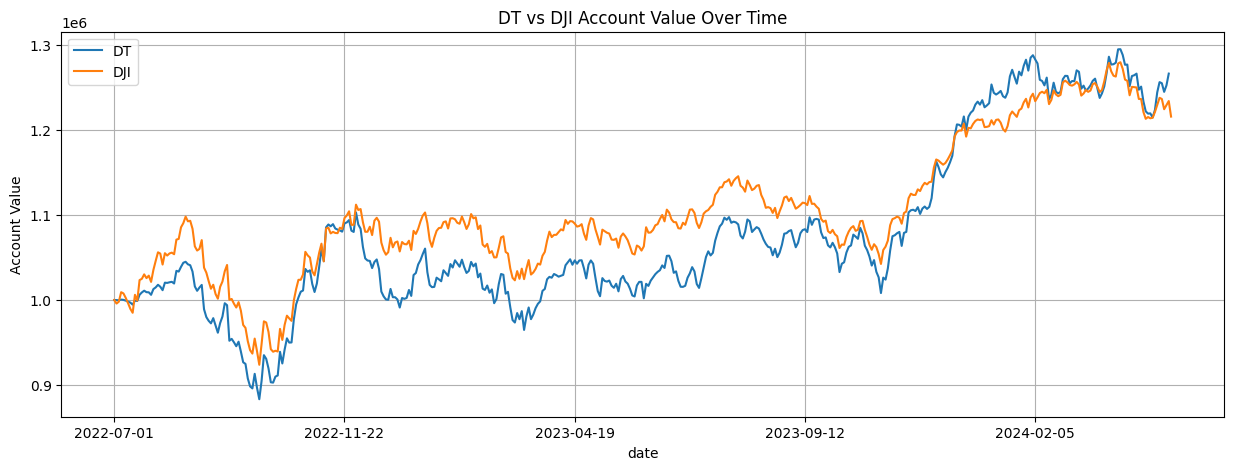

In [ ]:

plt.rcParams["figure.figsize"] = (15,5)
ax = result[['DT', 'DJI']].plot()
plt.title("DT vs DJI Account Value Over Time")
plt.xlabel("date")
plt.ylabel("Account Value")
plt.legend(["DT", "DJI"])
plt.grid(True)
plt.show()

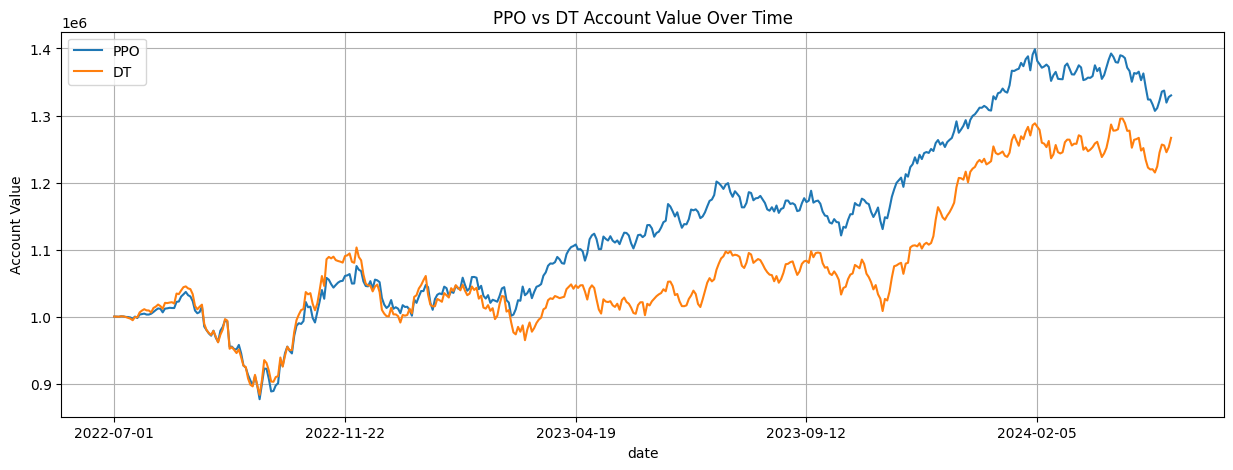

In [33]:
plt.rcParams['figure.figsize'] = (15,5)
ax = result[['PPO', 'DT']].plot()
plt.title('PPO vs DT Account Value Over Time')
plt.xlabel('date')
plt.ylabel('Account Value')
plt.legend(['PPO', 'DT'])
plt.grid(True)
plt.show()


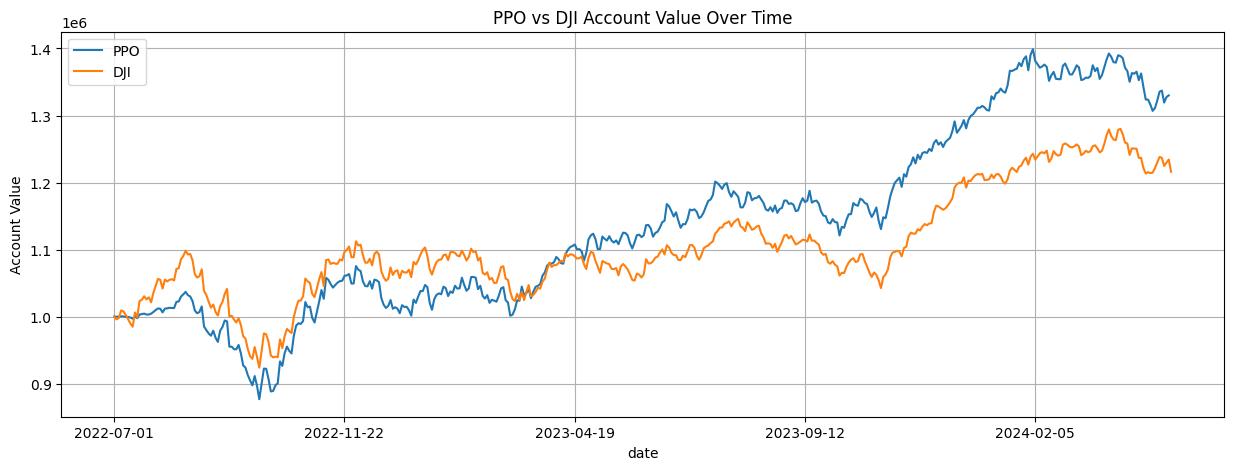

In [32]:
plt.rcParams['figure.figsize'] = (15, 5)
ax = result[['PPO', 'DJI']].plot()
plt.title('PPO vs DJI Account Value Over Time')
plt.xlabel('date')
plt.ylabel('Account Value')
plt.legend(['PPO', 'DJI'])
plt.grid(True)
plt.show()


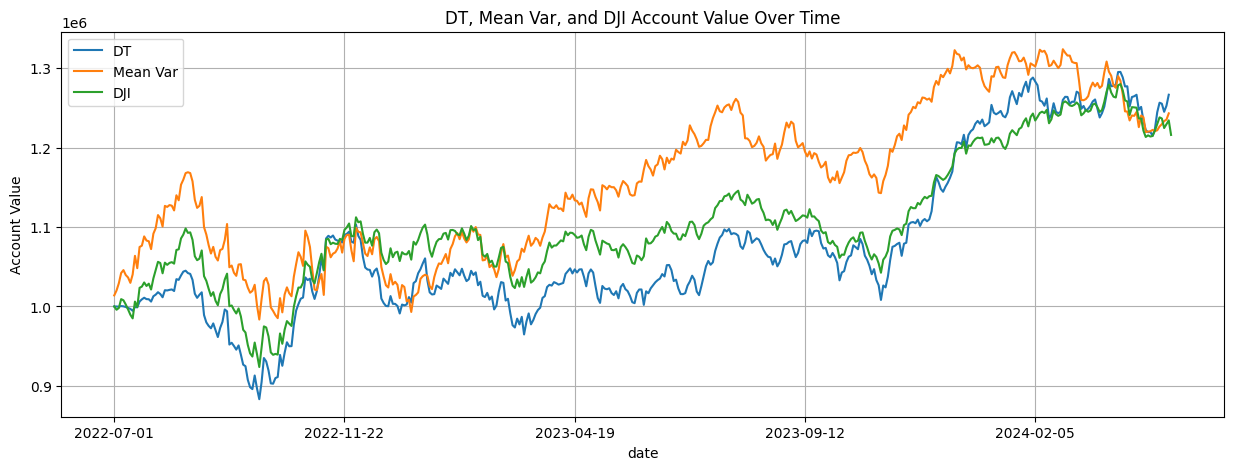

In [34]:
plt.rcParams['figure.figsize'] = (15, 5)
ax = result[['DT', 'Mean Var', 'DJI']].plot()
plt.title('DT, Mean Var, and DJI Account Value Over Time')
plt.xlabel('date')
plt.ylabel('Account Value')
plt.legend(['DT', 'Mean Var', 'DJI'])
plt.grid(True)
plt.show()



